In [1]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Examine data
csv_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv"
df = pd.read_csv(csv_path)

print(df.head())
print("\nColumns:", df.columns)
print("\nNumber of samples:", len(df))


            filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.05

Epoch 10/100 | Train Loss: 1.7997 | Val Loss: 1.9277 | Val Acc: 0.4473
Epoch 20/100 | Train Loss: 1.5401 | Val Loss: 1.4889 | Val Acc: 0.5220
Epoch 30/100 | Train Loss: 1.3622 | Val Loss: 1.2491 | Val Acc: 0.6262
Epoch 40/100 | Train Loss: 1.1987 | Val Loss: 1.0825 | Val Acc: 0.6836
Epoch 50/100 | Train Loss: 1.0600 | Val Loss: 0.9465 | Val Acc: 0.7336
Epoch 60/100 | Train Loss: 0.9619 | Val Loss: 0.8358 | Val Acc: 0.7690
Epoch 70/100 | Train Loss: 0.8664 | Val Loss: 0.7494 | Val Acc: 0.7884
Epoch 80/100 | Train Loss: 0.7759 | Val Loss: 0.6737 | Val Acc: 0.8011
Epoch 90/100 | Train Loss: 0.7112 | Val Loss: 0.6129 | Val Acc: 0.8144
Epoch 100/100 | Train Loss: 0.6459 | Val Loss: 0.5631 | Val Acc: 0.8284

 Final Results
Final Training Loss: 0.6459
Best Validation Loss: 0.5631
Best Validation Accuracy: 0.8284
Test Loss: 0.5414
Test Accuracy: 0.8179
Training Time: 41.47 seconds


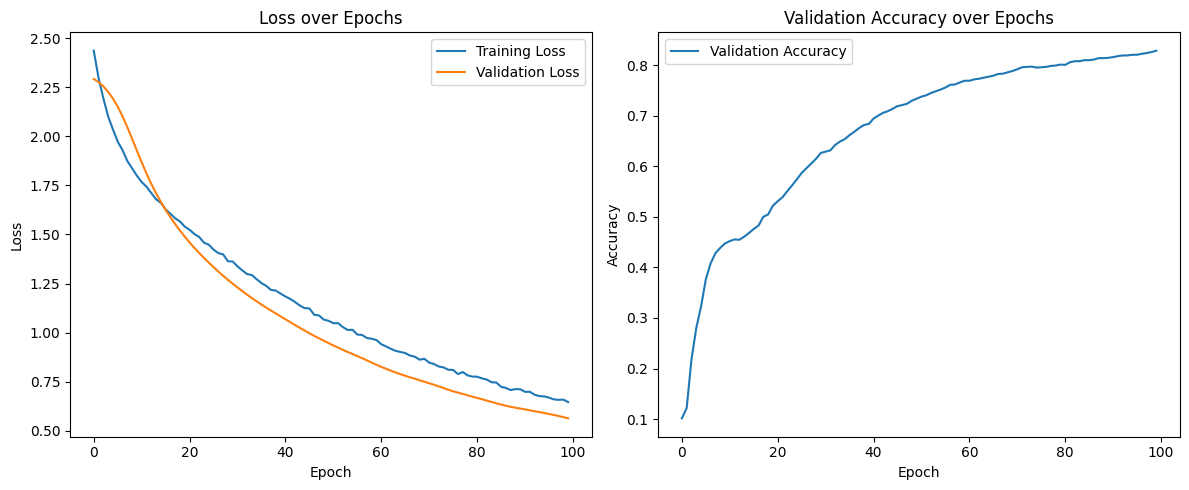

In [4]:
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


X = df.drop(columns=["filename", "label"]).values
y = df["label"].values

# labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Data split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Model
class DeepGenreNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x))); x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x))); x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x))); x = self.dropout(x)
        x = F.relu(self.bn4(self.fc4(x))); x = self.dropout(x)
        return self.fc5(x)

model = DeepGenreNet(input_dim=X_train.shape[1], num_classes=len(le.classes_))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

epochs = 100
best_val_acc = 0
early_stop_counter = 0

train_losses = []
val_losses = []
val_accuracies = []

start_time = time.time()

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    train_loss = criterion(outputs, y_train)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val).item()
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = accuracy_score(y_val, val_preds)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(1 - val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if early_stop_counter >= 15:
        print("Early stopping triggered!")
        break

total_time = time.time() - start_time

model.load_state_dict(best_model)

# Test metrics
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test).item()
    test_preds = torch.argmax(test_outputs, dim=1)
    test_acc = accuracy_score(y_test, test_preds)

print("\n Final Results")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Best Validation Loss: {min(val_losses):.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Training Time: {total_time:.2f} seconds")

# Plots
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


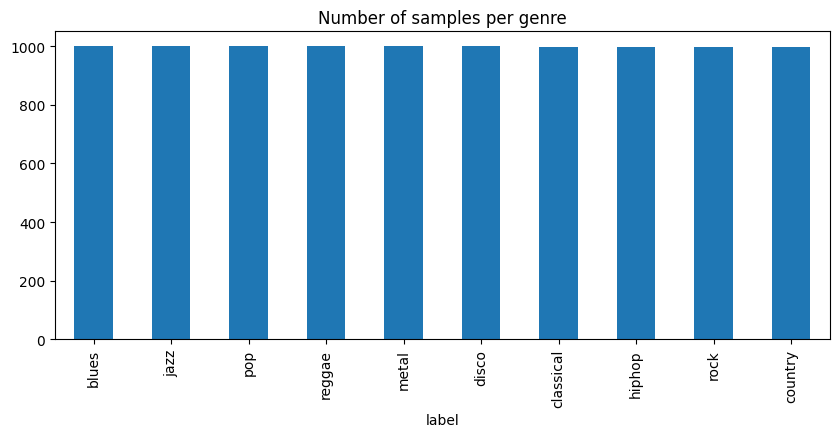

In [5]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar', figsize=(10, 4))
plt.title("Number of samples per genre")
plt.show()


In [6]:
X = df.drop(columns=["filename", "label"])
genres = sorted(df["label"].unique())
y = torch.tensor([genres.index(lbl) for lbl in df["label"]], dtype=torch.long)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = torch.tensor(X_scaled, dtype=torch.float32)

print("Feature tensor shape:", X.shape)
print("Label tensor shape:", y.shape)

Feature tensor shape: torch.Size([9990, 58])
Label tensor shape: torch.Size([9990])


In [7]:
import os

audio_dir = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"
genres = sorted(os.listdir(audio_dir))

print("Genres:", genres)

for g in genres:
    sample_files = os.listdir(os.path.join(audio_dir, g))[:3]
    print(f"{g}: {sample_files}")


Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
blues: ['blues.00039.wav', 'blues.00027.wav', 'blues.00005.wav']
classical: ['classical.00047.wav', 'classical.00021.wav', 'classical.00031.wav']
country: ['country.00027.wav', 'country.00049.wav', 'country.00008.wav']
disco: ['disco.00031.wav', 'disco.00089.wav', 'disco.00079.wav']
hiphop: ['hiphop.00062.wav', 'hiphop.00094.wav', 'hiphop.00055.wav']
jazz: ['jazz.00020.wav', 'jazz.00070.wav', 'jazz.00034.wav']
metal: ['metal.00021.wav', 'metal.00004.wav', 'metal.00026.wav']
pop: ['pop.00016.wav', 'pop.00030.wav', 'pop.00017.wav']
reggae: ['reggae.00079.wav', 'reggae.00002.wav', 'reggae.00049.wav']
rock: ['rock.00073.wav', 'rock.00004.wav', 'rock.00009.wav']


In [8]:
from IPython.display import Audio

# play sample file
genre = genres[0]
sample_file = os.listdir(os.path.join(audio_dir, genre))[0]
sample_path = os.path.join(audio_dir, genre, sample_file)

print(f"Playing: {sample_path}")
Audio(filename=sample_path)

Playing: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00039.wav


Sample rate: 22050, duration: 5.00s


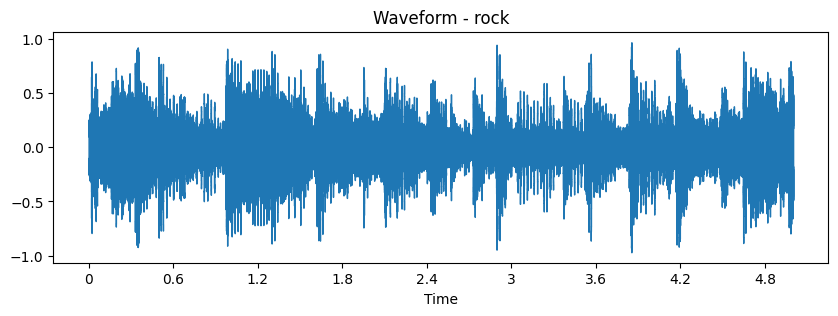

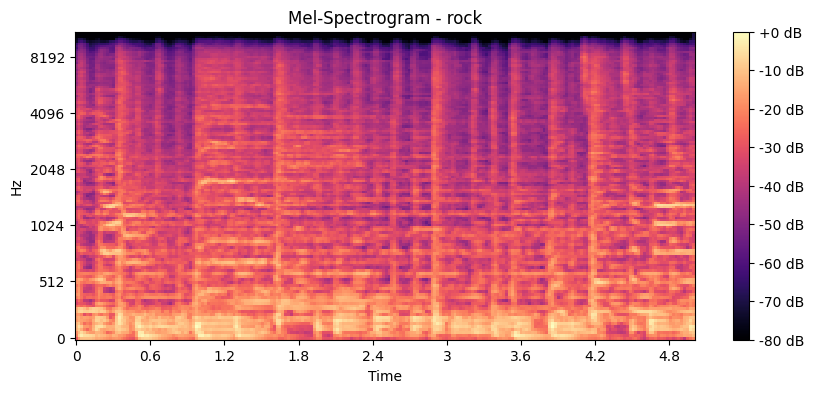

In [9]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np

genre = "rock"
file_path = os.path.join(audio_dir, genre, os.listdir(os.path.join(audio_dir, genre))[0])

y, sr = librosa.load(file_path, duration=5.0)
print(f"Sample rate: {sr}, duration: {len(y)/sr:.2f}s")

plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform - {genre}")
plt.show()

# Spectrogram
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel-Spectrogram - {genre}")
plt.show()
